### Import required Packages and gathering Data

In [126]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

In [65]:
crop_df = pd.read_excel("Crop_data.xlsx", sheet_name="Sheet1")
crop_yield_df = pd.read_csv("D:/All_Projects/splitmindz/Crop_Yield_Prediction.csv")
# concat_df = pd.concat([crop_df, crop_yield_df], axis = 1)
crop_yield_df.describe()

,Nitrogen,Phosphorus,Potassium,Temperature,Humidity,pH_Value,Rainfall,Yield
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655,2689.228182
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389,3710.361267
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267,2.000000
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686,950.000000
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624,1825.000000
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508,3500.000000
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117,120000.000000


In [66]:
weather_data = pd.DataFrame({
    "Humidity":np.random.uniform(15, 100, len(crop_df)),
    "pH_Value": np.random.uniform(3, 10, len(crop_df)),
    'temperature': np.random.uniform(8, 45, len(crop_df)),  # Random temperatures between 20 and 35 degrees Celsius
    'rainfall': np.random.uniform(20, 300, len(crop_df))      # Random rainfall between 0 and 20 mm
})

# Generate synthetic market trend data
market_data = pd.DataFrame({
    'demand_index': np.random.uniform(80, 150, len(crop_df)),  # Random demand index between 80 and 150
    'supply_index': np.random.uniform(90, 120, len(crop_df))   # Random supply index between 90 and 120
})

weather_data.describe()
market_data.describe()

,demand_index,supply_index
count,132.000000,132.000000
mean,115.647115,104.890729
std,19.618529,8.525002
min,80.747953,90.248551
25%,97.731715,96.452136
50%,116.189196,105.934449
75%,133.327582,111.775533
max,148.810007,119.885382


In [67]:
concated_data = pd.concat([crop_df, weather_data, market_data], axis = 1)
concated_data.head()

,State,District,Crop,Current_price,Stage,Preparation_Activity,Sowing_Date,Fertilization,Irrigation,Area (in hectares),Required Production per Year,Humidity,pH_Value,temperature,rainfall,demand_index,supply_index
0,Maharashtra,Ahmednagar,Ragi,28.39,Preparation,Plowing,2024-01-15,Tillage,NaN,100,6129.856,84.834811,9.067378,39.937426,187.437490,141.278582,92.999164
1,Maharashtra,Ahmednagar,Ragi,25.71,Preparation,Weeding,2024-01-20,NaN,NaN,100,5446.704,85.894892,5.072109,34.159178,274.226948,142.002445,94.481521
2,Maharashtra,Ahmednagar,Ragi,27.05,Preparation,Fertilizer application,2024-01-25,Organic manure,NaN,100,5985.228,79.649852,7.186445,38.807784,175.314058,130.237297,104.941653
3,Maharashtra,Ahmednagar,Ragi,34.08,Preparation,Seed selection,2024-01-30,NaN,NaN,100,5886.888,21.103355,4.319409,15.008008,208.560083,94.149667,114.161379
4,Maharashtra,Pune,Ragi,29.76,Preparation,Plowing,2024-01-20,Tillage,NaN,150,7170.876,58.622013,9.686327,37.475454,91.843447,109.882740,99.136927


In [68]:
concated_data.columns

Index(['State', 'District', 'Crop', 'Current_price', 'Stage',
       'Preparation_Activity', 'Sowing_Date', 'Fertilization', 'Irrigation',
       'Area (in hectares)', 'Required Production per Year', 'Humidity',
       'pH_Value', 'temperature', 'rainfall', 'demand_index', 'supply_index'],
      dtype='object')

In [69]:
concated_data.isnull().sum()

State                             0
District                          0
Crop                              0
Current_price                     0
Stage                             0
Preparation_Activity              0
Sowing_Date                       0
Fertilization                    66
Irrigation                      132
Area (in hectares)                0
Required Production per Year      0
Humidity                          0
pH_Value                          0
temperature                       0
rainfall                          0
demand_index                      0
supply_index                      0
dtype: int64

### Anaysis and Preprocessing

#### Analysis

In [70]:
concated_data.shape

(132, 17)

In [71]:
concated_data.head()

,State,District,Crop,Current_price,Stage,Preparation_Activity,Sowing_Date,Fertilization,Irrigation,Area (in hectares),Required Production per Year,Humidity,pH_Value,temperature,rainfall,demand_index,supply_index
0,Maharashtra,Ahmednagar,Ragi,28.39,Preparation,Plowing,2024-01-15,Tillage,NaN,100,6129.856,84.834811,9.067378,39.937426,187.437490,141.278582,92.999164
1,Maharashtra,Ahmednagar,Ragi,25.71,Preparation,Weeding,2024-01-20,NaN,NaN,100,5446.704,85.894892,5.072109,34.159178,274.226948,142.002445,94.481521
2,Maharashtra,Ahmednagar,Ragi,27.05,Preparation,Fertilizer application,2024-01-25,Organic manure,NaN,100,5985.228,79.649852,7.186445,38.807784,175.314058,130.237297,104.941653
3,Maharashtra,Ahmednagar,Ragi,34.08,Preparation,Seed selection,2024-01-30,NaN,NaN,100,5886.888,21.103355,4.319409,15.008008,208.560083,94.149667,114.161379
4,Maharashtra,Pune,Ragi,29.76,Preparation,Plowing,2024-01-20,Tillage,NaN,150,7170.876,58.622013,9.686327,37.475454,91.843447,109.882740,99.136927


In [72]:
concated_data.tail()

,State,District,Crop,Current_price,Stage,Preparation_Activity,Sowing_Date,Fertilization,Irrigation,Area (in hectares),Required Production per Year,Humidity,pH_Value,temperature,rainfall,demand_index,supply_index
127,Madhya Pradesh,Jabalpur,Maize,33.17,Preparation,Seed selection,2024-02-10,NaN,NaN,300,6220.368,40.211236,7.190211,39.146453,177.296310,124.484976,105.841025
128,Madhya Pradesh,Gwalior,Maize,30.42,Preparation,Plowing,2024-01-20,Tillage,NaN,350,5451.144,24.052704,9.121651,20.670270,82.687539,133.827487,102.147181
129,Madhya Pradesh,Gwalior,Maize,31.81,Preparation,Weeding,2024-01-25,NaN,NaN,350,6383.148,57.235914,9.357474,29.579833,209.334621,128.990053,115.776459
130,Madhya Pradesh,Gwalior,Maize,32.67,Preparation,Fertilizer application,2024-01-30,Organic manure,NaN,350,6325.464,15.484611,4.279528,38.515632,237.147033,105.398087,115.713400
131,Madhya Pradesh,Gwalior,Maize,29.79,Preparation,Seed selection,2024-02-05,NaN,NaN,350,6001.548,43.903944,3.231330,26.099129,44.018633,126.420907,108.697735


In [73]:
concated_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   State                         132 non-null    object        
 1   District                      132 non-null    object        
 2   Crop                          132 non-null    object        
 3   Current_price                 132 non-null    float64       
 4   Stage                         132 non-null    object        
 5   Preparation_Activity          132 non-null    object        
 6   Sowing_Date                   132 non-null    datetime64[ns]
 7   Fertilization                 66 non-null     object        
 8   Irrigation                    0 non-null      float64       
 9   Area (in hectares)            132 non-null    int64         
 10  Required Production per Year  132 non-null    float64       
 11  Humidity                      13

In [74]:
concated_data["Crop"].value_counts()

Crop
Wheat        24
Ragi         16
Onion        16
Rice         16
Tomato       12
Sorghum       8
Barley        8
Groundnut     8
Cotton        8
Soybean       8
Maize         8
Name: count, dtype: int64

In [75]:
concated_data.describe(include="O")

,State,District,Crop,Stage,Preparation_Activity,Fertilization
count,132,132,132,132,132,66
unique,8,33,11,1,4,2
top,Maharashtra,Ahmednagar,Wheat,Preparation,Plowing,Tillage
freq,20,4,24,132,33,33


In [76]:
concated_data.describe()

,Current_price,Sowing_Date,Irrigation,Area (in hectares),Required Production per Year,Humidity,pH_Value,temperature,rainfall,demand_index,supply_index
count,132.000000,132,0.0,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000
mean,30.430606,2024-05-15 10:54:32.727272704,NaN,254.545455,6073.584152,54.805972,6.423821,26.025188,150.992258,115.647115,104.890729
min,25.610000,2024-01-15 00:00:00,NaN,100.000000,4736.808000,15.277152,3.026786,8.118487,20.153168,80.747953,90.248551
25%,29.035000,2024-02-04 00:00:00,NaN,200.000000,5700.297000,34.911792,4.739022,16.475500,85.807517,97.731715,96.452136
50%,30.425000,2024-02-27 12:00:00,NaN,250.000000,6048.282000,54.521185,6.381553,25.502100,147.154290,116.189196,105.934449
75%,31.912500,2024-10-20 00:00:00,NaN,300.000000,6405.942000,76.992338,8.439751,35.781695,211.568626,133.327582,111.775533
max,34.670000,2024-11-05 00:00:00,NaN,350.000000,7357.548000,99.859134,9.996109,44.486633,298.479364,148.810007,119.885382
std,1.956230,NaN,NaN,68.085752,567.756690,25.550123,2.103684,10.942250,80.534722,19.618529,8.525002


#### Handling Missing values

In [84]:
crop_data = concated_data.copy()

In [85]:
crop_data.isna().sum()

State                             0
District                          0
Crop                              0
Current_price                     0
Stage                             0
Preparation_Activity              0
Sowing_Date                       0
Fertilization                    66
Irrigation                      132
Area (in hectares)                0
Required Production per Year      0
Humidity                          0
pH_Value                          0
temperature                       0
rainfall                          0
demand_index                      0
supply_index                      0
dtype: int64

In [86]:
crop_data["Fertilization"].value_counts()

Fertilization
Tillage           33
Organic manure    33
Name: count, dtype: int64

In [87]:
crop_data["Irrigation"].value_counts()

Series([], Name: count, dtype: int64)

In [88]:
crop_data["Preparation_Activity"].value_counts()

Preparation_Activity
Plowing                   33
Weeding                   33
Fertilizer application    33
Seed selection            33
Name: count, dtype: int64

In [89]:
crop_data["Crop"].value_counts()

Crop
Wheat        24
Ragi         16
Onion        16
Rice         16
Tomato       12
Sorghum       8
Barley        8
Groundnut     8
Cotton        8
Soybean       8
Maize         8
Name: count, dtype: int64

In [90]:
# crop_data.to_csv("merged_crop_df.csv")

In [91]:
# Define irrigation rules based on crop type and sowing season
def determine_irrigation(row):
    crop = row['Crop']
    if crop == 'Rice':
        return 'Flood'
    elif crop in ['Wheat', 'Barley', 'Ragi', 'Sorghum', 'Groundnut', 'Soybean', 'Maize']:
        return 'Sprinkler'
    elif crop in ['Tomato', 'Onion', 'Cotton']:
        return 'Drip'
    else:
        return 'None'

In [92]:
# Apply the function to create the 'Irrigation' feature
crop_data['Irrigation'] = crop_data.apply(determine_irrigation, axis=1)

In [93]:
crop_data["Irrigation"].value_counts()

Irrigation
Sprinkler    80
Drip         36
Flood        16
Name: count, dtype: int64

In [94]:
crop_data.isnull().sum()

State                            0
District                         0
Crop                             0
Current_price                    0
Stage                            0
Preparation_Activity             0
Sowing_Date                      0
Fertilization                   66
Irrigation                       0
Area (in hectares)               0
Required Production per Year     0
Humidity                         0
pH_Value                         0
temperature                      0
rainfall                         0
demand_index                     0
supply_index                     0
dtype: int64

In [95]:
crop_data.ffill(inplace=True)

In [96]:
crop_data.isnull().sum()

State                           0
District                        0
Crop                            0
Current_price                   0
Stage                           0
Preparation_Activity            0
Sowing_Date                     0
Fertilization                   0
Irrigation                      0
Area (in hectares)              0
Required Production per Year    0
Humidity                        0
pH_Value                        0
temperature                     0
rainfall                        0
demand_index                    0
supply_index                    0
dtype: int64

In [97]:
crop_data.head()

,State,District,Crop,Current_price,Stage,Preparation_Activity,Sowing_Date,Fertilization,Irrigation,Area (in hectares),Required Production per Year,Humidity,pH_Value,temperature,rainfall,demand_index,supply_index
0,Maharashtra,Ahmednagar,Ragi,28.39,Preparation,Plowing,2024-01-15,Tillage,Sprinkler,100,6129.856,84.834811,9.067378,39.937426,187.437490,141.278582,92.999164
1,Maharashtra,Ahmednagar,Ragi,25.71,Preparation,Weeding,2024-01-20,Tillage,Sprinkler,100,5446.704,85.894892,5.072109,34.159178,274.226948,142.002445,94.481521
2,Maharashtra,Ahmednagar,Ragi,27.05,Preparation,Fertilizer application,2024-01-25,Organic manure,Sprinkler,100,5985.228,79.649852,7.186445,38.807784,175.314058,130.237297,104.941653
3,Maharashtra,Ahmednagar,Ragi,34.08,Preparation,Seed selection,2024-01-30,Organic manure,Sprinkler,100,5886.888,21.103355,4.319409,15.008008,208.560083,94.149667,114.161379
4,Maharashtra,Pune,Ragi,29.76,Preparation,Plowing,2024-01-20,Tillage,Sprinkler,150,7170.876,58.622013,9.686327,37.475454,91.843447,109.882740,99.136927


In [98]:
crop_data["Fertilization"].value_counts()

Fertilization
Tillage           66
Organic manure    66
Name: count, dtype: int64

In [99]:
handle_missing_crop_data = crop_data.copy()

#### Feature Engineering

In [100]:
# Date Feature Engineering
handle_missing_crop_data['Sowing_Date'] = pd.to_datetime(handle_missing_crop_data['Sowing_Date'], errors='coerce')
handle_missing_crop_data['Sowing_Month'] = handle_missing_crop_data['Sowing_Date'].dt.month
handle_missing_crop_data['Sowing_Season'] = handle_missing_crop_data['Sowing_Date'].dt.quarter
handle_missing_crop_data['Days_Since_Sowing'] = (datetime.now() - handle_missing_crop_data['Sowing_Date']).dt.days

In [101]:
# Drop original Sowing_Date as we have extracted useful features
handle_missing_crop_data.drop(columns=['Sowing_Date'], inplace=True)

In [102]:
handle_missing_crop_data["Sowing_Season"].value_counts()

Sowing_Season
1    83
4    48
2     1
Name: count, dtype: int64

In [103]:
feature_engineer_crop_data = handle_missing_crop_data.copy()
feature_engineer_crop_data.head()

,State,District,Crop,Current_price,Stage,Preparation_Activity,Fertilization,Irrigation,Area (in hectares),Required Production per Year,Humidity,pH_Value,temperature,rainfall,demand_index,supply_index,Sowing_Month,Sowing_Season,Days_Since_Sowing
0,Maharashtra,Ahmednagar,Ragi,28.39,Preparation,Plowing,Tillage,Sprinkler,100,6129.856,84.834811,9.067378,39.937426,187.437490,141.278582,92.999164,1,1,227
1,Maharashtra,Ahmednagar,Ragi,25.71,Preparation,Weeding,Tillage,Sprinkler,100,5446.704,85.894892,5.072109,34.159178,274.226948,142.002445,94.481521,1,1,222
2,Maharashtra,Ahmednagar,Ragi,27.05,Preparation,Fertilizer application,Organic manure,Sprinkler,100,5985.228,79.649852,7.186445,38.807784,175.314058,130.237297,104.941653,1,1,217
3,Maharashtra,Ahmednagar,Ragi,34.08,Preparation,Seed selection,Organic manure,Sprinkler,100,5886.888,21.103355,4.319409,15.008008,208.560083,94.149667,114.161379,1,1,212
4,Maharashtra,Pune,Ragi,29.76,Preparation,Plowing,Tillage,Sprinkler,150,7170.876,58.622013,9.686327,37.475454,91.843447,109.882740,99.136927,1,1,222


#### Handling Outliers

In [170]:
feature_engineer_crop_data.describe()

,Current_price,Area (in hectares),Required Production per Year,Humidity,pH_Value,temperature,rainfall,demand_index,supply_index,Sowing_Month,Sowing_Season,Days_Since_Sowing
count,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000
mean,30.430606,254.545455,6073.584152,54.805972,6.423821,26.025188,150.992258,115.647115,104.890729,4.871212,2.098485,105.545455
std,1.956230,68.085752,567.756690,25.550123,2.103684,10.942250,80.534722,19.618529,8.525002,4.038754,1.445498,124.605721
min,25.610000,100.000000,4736.808000,15.277152,3.026786,8.118487,20.153168,80.747953,90.248551,1.000000,1.000000,-68.000000
25%,29.035000,200.000000,5700.297000,34.911792,4.739022,16.475500,85.807517,97.731715,96.452136,2.000000,1.000000,-52.000000
50%,30.425000,250.000000,6048.282000,54.521185,6.381553,25.502100,147.154290,116.189196,105.934449,2.500000,1.000000,183.500000
75%,31.912500,300.000000,6405.942000,76.992338,8.439751,35.781695,211.568626,133.327582,111.775533,10.000000,4.000000,207.000000
max,34.670000,350.000000,7357.548000,99.859134,9.996109,44.486633,298.479364,148.810007,119.885382,11.000000,4.000000,227.000000


In [171]:
def detect_outliers(df):
    l = []
    for i in df.columns:
        if df[i].dtypes != "O":
            Q1 = np.percentile(df[i], 25)
            Q3 = np.percentile(df[i], 75)
            IQR = Q3-Q1
            Quartile_dev = (Q3-Q1)/2
            up = Q3 + 1.5*IQR
            lb = Q1 - 1.5*IQR
            std = df[i].std()
            l.append([np.round(j, 2) for j in [Q1, Q3, IQR, Quartile_dev, up, lb, std]])
            get_outlier = df[(df[i]<lb) | (df[i]>up)]
    return get_outlier

In [172]:
detect_outliers(feature_engineer_crop_data)

,State,District,Crop,Current_price,Stage,Preparation_Activity,Fertilization,Irrigation,Area (in hectares),Required Production per Year,Humidity,pH_Value,temperature,rainfall,demand_index,supply_index,Sowing_Month,Sowing_Season,Days_Since_Sowing


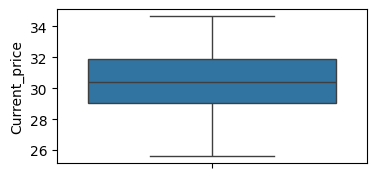

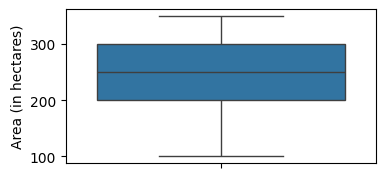

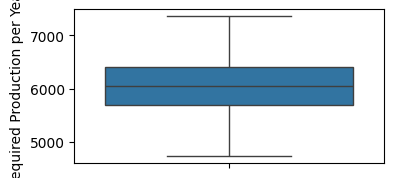

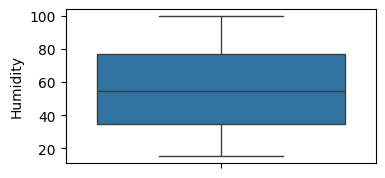

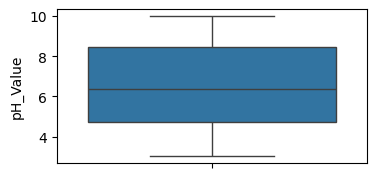

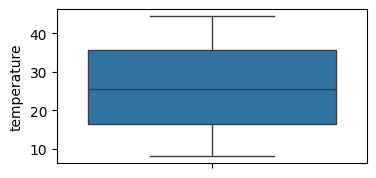

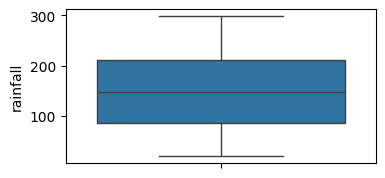

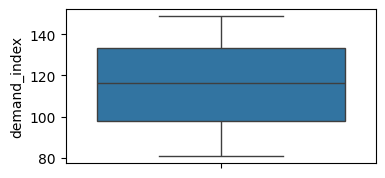

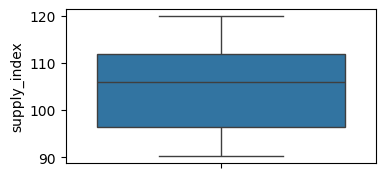

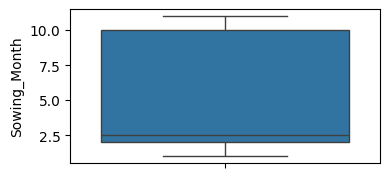

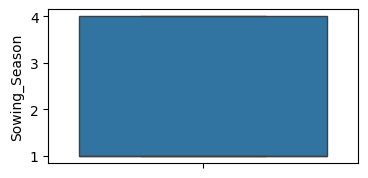

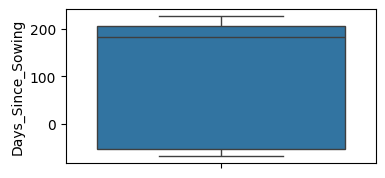

In [173]:
for i in feature_engineer_crop_data.columns:
      if feature_engineer_crop_data[i].dtypes != "O":
        plt.figure(figsize=(4,2))
        sns.boxplot(feature_engineer_crop_data[i])
        plt.show()

In [174]:
detect_outliers_crop_data = feature_engineer_crop_data.copy()

In [175]:
detect_outliers_crop_data.head()

,State,District,Crop,Current_price,Stage,Preparation_Activity,Fertilization,Irrigation,Area (in hectares),Required Production per Year,Humidity,pH_Value,temperature,rainfall,demand_index,supply_index,Sowing_Month,Sowing_Season,Days_Since_Sowing
0,Maharashtra,Ahmednagar,Ragi,28.39,Preparation,Plowing,Tillage,Sprinkler,100,6129.856,84.834811,9.067378,39.937426,187.437490,141.278582,92.999164,1,1,227
1,Maharashtra,Ahmednagar,Ragi,25.71,Preparation,Weeding,Tillage,Sprinkler,100,5446.704,85.894892,5.072109,34.159178,274.226948,142.002445,94.481521,1,1,222
2,Maharashtra,Ahmednagar,Ragi,27.05,Preparation,Fertilizer application,Organic manure,Sprinkler,100,5985.228,79.649852,7.186445,38.807784,175.314058,130.237297,104.941653,1,1,217
3,Maharashtra,Ahmednagar,Ragi,34.08,Preparation,Seed selection,Organic manure,Sprinkler,100,5886.888,21.103355,4.319409,15.008008,208.560083,94.149667,114.161379,1,1,212
4,Maharashtra,Pune,Ragi,29.76,Preparation,Plowing,Tillage,Sprinkler,150,7170.876,58.622013,9.686327,37.475454,91.843447,109.882740,99.136927,1,1,222


#### Encoding categorical features

In [176]:
# Encoding categorical features
categorical_features = ['State', 'District', 'Stage', 'Crop', 'Preparation_Activity', 'Fertilization', 'Irrigation']
numerical_features = ['Area (in hectares)', 'Required Production per Year', 'Sowing_Month', 'Sowing_Season', 'Days_Since_Sowing']

In [178]:
detect_outliers_crop_data.dtypes

State                            object
District                         object
Crop                             object
Current_price                   float64
Stage                            object
Preparation_Activity             object
Fertilization                    object
Irrigation                       object
Area (in hectares)                int64
Required Production per Year    float64
Humidity                        float64
pH_Value                        float64
temperature                     float64
rainfall                        float64
demand_index                    float64
supply_index                    float64
Sowing_Month                      int32
Sowing_Season                     int32
Days_Since_Sowing                 int64
dtype: object

In [179]:
le = LabelEncoder()
for i in detect_outliers_crop_data[categorical_features]:
    detect_outliers_crop_data[i] = le.fit_transform(detect_outliers_crop_data[i])


In [180]:
detect_outliers_crop_data.dtypes

State                             int32
District                          int32
Crop                              int32
Current_price                   float64
Stage                             int32
Preparation_Activity              int32
Fertilization                     int32
Irrigation                        int32
Area (in hectares)                int64
Required Production per Year    float64
Humidity                        float64
pH_Value                        float64
temperature                     float64
rainfall                        float64
demand_index                    float64
supply_index                    float64
Sowing_Month                      int32
Sowing_Season                     int32
Days_Since_Sowing                 int64
dtype: object

In [181]:
detect_outliers_crop_data.head()

,State,District,Crop,Current_price,Stage,Preparation_Activity,Fertilization,Irrigation,Area (in hectares),Required Production per Year,Humidity,pH_Value,temperature,rainfall,demand_index,supply_index,Sowing_Month,Sowing_Season,Days_Since_Sowing
0,3,2,5,28.39,0,1,1,2,100,6129.856,84.834811,9.067378,39.937426,187.437490,141.278582,92.999164,1,1,227
1,3,2,5,25.71,0,3,1,2,100,5446.704,85.894892,5.072109,34.159178,274.226948,142.002445,94.481521,1,1,222
2,3,2,5,27.05,0,0,0,2,100,5985.228,79.649852,7.186445,38.807784,175.314058,130.237297,104.941653,1,1,217
3,3,2,5,34.08,0,2,0,2,100,5886.888,21.103355,4.319409,15.008008,208.560083,94.149667,114.161379,1,1,212
4,3,25,5,29.76,0,1,1,2,150,7170.876,58.622013,9.686327,37.475454,91.843447,109.882740,99.136927,1,1,222


In [182]:
detect_outliers_crop_data.describe()

,State,District,Crop,Current_price,Stage,Preparation_Activity,Fertilization,Irrigation,Area (in hectares),Required Production per Year,Humidity,pH_Value,temperature,rainfall,demand_index,supply_index,Sowing_Month,Sowing_Season,Days_Since_Sowing
count,132.000000,132.000000,132.000000,132.000000,132.0,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000
mean,3.484848,16.000000,5.727273,30.430606,0.0,1.500000,0.500000,1.333333,254.545455,6073.584152,54.805972,6.423821,26.025188,150.992258,115.647115,104.890729,4.871212,2.098485,105.545455
std,2.266533,9.558179,3.138266,1.956230,0.0,1.122293,0.501905,0.879509,68.085752,567.756690,25.550123,2.103684,10.942250,80.534722,19.618529,8.525002,4.038754,1.445498,124.605721
min,0.000000,0.000000,0.000000,25.610000,0.0,0.000000,0.000000,0.000000,100.000000,4736.808000,15.277152,3.026786,8.118487,20.153168,80.747953,90.248551,1.000000,1.000000,-68.000000
25%,2.000000,8.000000,4.000000,29.035000,0.0,0.750000,0.000000,0.000000,200.000000,5700.297000,34.911792,4.739022,16.475500,85.807517,97.731715,96.452136,2.000000,1.000000,-52.000000
50%,3.000000,16.000000,6.000000,30.425000,0.0,1.500000,0.500000,2.000000,250.000000,6048.282000,54.521185,6.381553,25.502100,147.154290,116.189196,105.934449,2.500000,1.000000,183.500000
75%,5.000000,24.000000,9.000000,31.912500,0.0,2.250000,1.000000,2.000000,300.000000,6405.942000,76.992338,8.439751,35.781695,211.568626,133.327582,111.775533,10.000000,4.000000,207.000000
max,7.000000,32.000000,10.000000,34.670000,0.0,3.000000,1.000000,2.000000,350.000000,7357.548000,99.859134,9.996109,44.486633,298.479364,148.810007,119.885382,11.000000,4.000000,227.000000


In [184]:
encode_crop_data = detect_outliers_crop_data.copy()

#### Correlation Matrixs

In [185]:
crop_corr_df = encode_crop_data.corr().abs() 

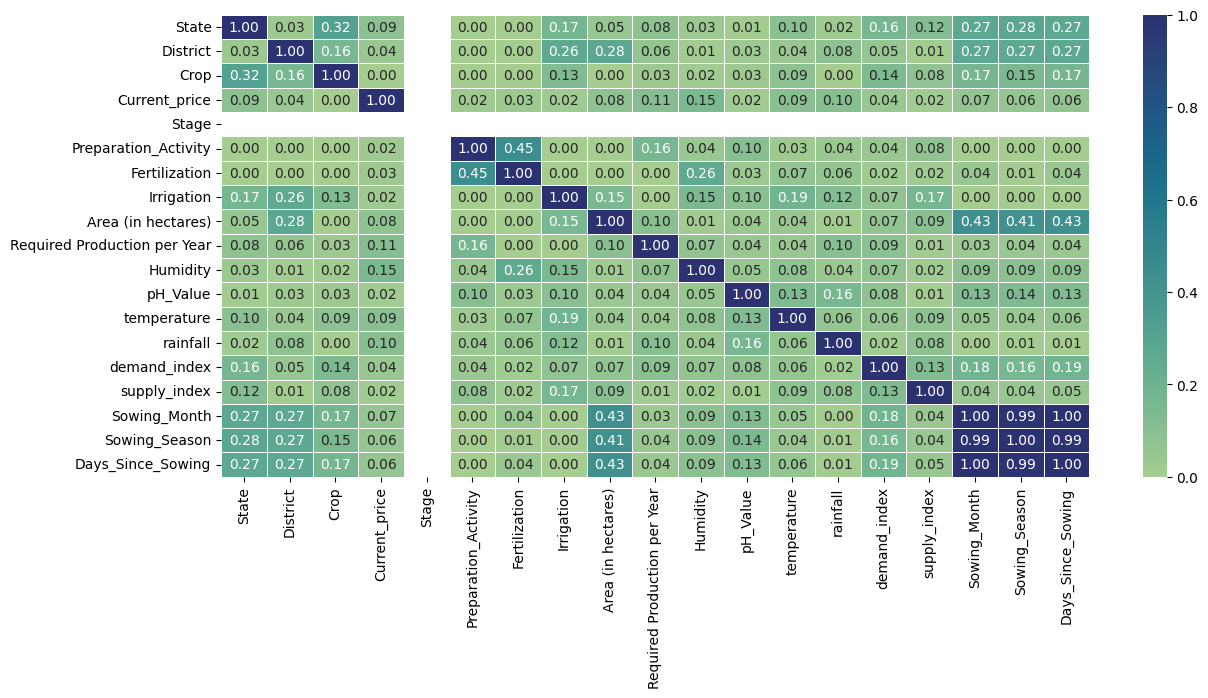

In [186]:
plt.figure(figsize=(14,6))
sns.heatmap(crop_corr_df, annot=True, fmt=".2f", linewidths=.5, cmap="crest")
plt.show()

In [187]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
interaction_features = poly.fit_transform(encode_crop_data[['Crop', 'Sowing_Season']])

In [188]:
poly.get_feature_names_out(["Crop","Sowing_Season"])

array(['Crop', 'Sowing_Season', 'Crop Sowing_Season'], dtype=object)

In [189]:
interaction_data = pd.DataFrame(interaction_features, columns = poly.get_feature_names_out(["Crop","Sowing_Season"]))
concat_crop = pd.concat([encode_crop_data, interaction_data], axis = 1)
remove_duplicate_crop_df = concat_crop.loc[:, ~concat_crop.columns.duplicated()]
remove_duplicate_crop_df.drop(["Crop","Sowing_Season"], axis = 1, inplace=True)

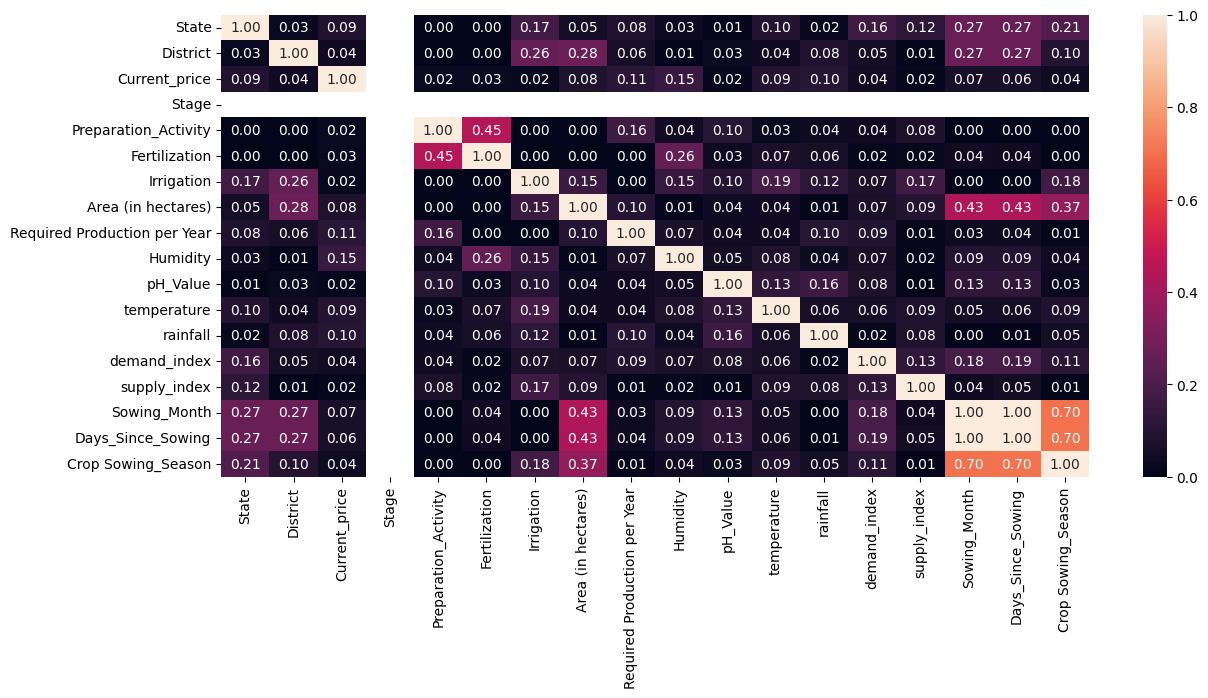

In [190]:
plt.figure(figsize=(14,6))
sns.heatmap(remove_duplicate_crop_df.corr().abs(), annot=True, fmt = ".2f")
plt.show()

In [191]:
threshold = 0.9

,State,District,Current_price,Stage,Preparation_Activity,Fertilization,Irrigation,Area (in hectares),Required Production per Year,Humidity,pH_Value,temperature,rainfall,demand_index,supply_index,Sowing_Month,Days_Since_Sowing,Crop Sowing_Season
0,3,2,28.39,0,1,1,2,100,6129.856,84.834811,9.067378,39.937426,187.437490,141.278582,92.999164,1,227,5.0
1,3,2,25.71,0,3,1,2,100,5446.704,85.894892,5.072109,34.159178,274.226948,142.002445,94.481521,1,222,5.0
2,3,2,27.05,0,0,0,2,100,5985.228,79.649852,7.186445,38.807784,175.314058,130.237297,104.941653,1,217,5.0
3,3,2,34.08,0,2,0,2,100,5886.888,21.103355,4.319409,15.008008,208.560083,94.149667,114.161379,1,212,5.0
4,3,25,29.76,0,1,1,2,150,7170.876,58.622013,9.686327,37.475454,91.843447,109.882740,99.136927,1,222,5.0


##### Scalling the features

In [ ]:
# Split data into training and testing sets
X = detect_outliers_crop_data.drop(['Current_price', "Stage"], axis=1)
y = detect_outliers_crop_data['Current_price']

In [158]:
ss = StandardScaler()
X = ss.fit_transform(remove_duplicate_crop_df)
X[:1]

array([[-0.21473125, -1.47029409, -0.4472136 ,  1.        ,  0.76088591,
        -2.27851196,  0.09949019,  1.17976868,  1.26141944,  1.27626734,
         0.45426457,  1.31146997, -1.40021856, -0.96216802,  0.97842403,
        -0.5652526 ]])

##### Feature selection

#### Model Building

In [959]:
models = {"svr": SVR(), "randomforestR": RandomForestRegressor(), "XGBoostR": XGBRegressor(), "gbr": GradientBoostingRegressor(), "abr": AdaBoostRegressor(), "lr": LinearRegression(), "dtr": DecisionTreeRegressor()}

In [962]:
def model_building(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    for m in models.values():
        m.fit(X_train, y_train)
        y_pred = m.predict(X_test)
        # Evaluate the model
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        print(f"\n{m}")
        print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
        print(f"R² Score: {r2:.2f}")
        print(f"Mean Absolute Error (MAE): {mae:.2f}")
        df = pd.DataFrame([y_pred, y_test]).T
    

In [963]:
model_building(remove_duplicate_crop_df, y)


SVR()
Root Mean Squared Error (RMSE): 1.94
R² Score: -0.03
Mean Absolute Error (MAE): 1.64

RandomForestRegressor()
Root Mean Squared Error (RMSE): 2.03
R² Score: -0.13
Mean Absolute Error (MAE): 1.69

GradientBoostingRegressor()
Root Mean Squared Error (RMSE): 2.38
R² Score: -0.56
Mean Absolute Error (MAE): 2.04

AdaBoostRegressor()
Root Mean Squared Error (RMSE): 2.03
R² Score: -0.14
Mean Absolute Error (MAE): 1.73

LinearRegression()
Root Mean Squared Error (RMSE): 2.36
R² Score: -0.53
Mean Absolute Error (MAE): 1.92

DecisionTreeRegressor()
Root Mean Squared Error (RMSE): 3.00
R² Score: -1.49
Mean Absolute Error (MAE): 2.60


In [964]:
X_train, X_test, y_train, y_test = train_test_split(remove_duplicate_crop_df, y, test_size=0.2, random_state=42)

In [965]:
X_train.head()

,State,District,Crop,Preparation_Activity,Fertilization,Irrigation,Area (in hectares),Required Production per Year,temperature,rainfall,demand_index,supply_index,Sowing_Month,Sowing_Season,Days_Since_Sowing,Crop Sowing_Season
95,5,30,0,2,0,2,300,5948.868,23.805125,18.976409,107.385017,119.879287,10,4,-63,0.0
96,5,7,0,1,1,2,350,5651.688,26.558558,15.015195,91.662128,99.253661,10,4,-53,0.0
0,3,2,5,1,1,2,100,6129.856,24.796190,7.189552,117.431731,115.246464,1,1,226,5.0
12,3,22,4,1,1,0,150,6708.564,35.445396,17.572723,129.643302,116.084648,10,4,-53,16.0
126,2,13,3,0,0,2,300,5958.456,24.669103,16.279663,99.475925,107.402144,2,1,205,3.0


In [966]:
y_train[:6]

95     32.61
96     30.05
0      28.39
12     31.41
126    30.99
70     27.84
Name: Current_price, dtype: float64

In [967]:
rfr = RandomForestRegressor(n_estimators=100, max_depth=6, random_state=22)

In [968]:
# Train the model
rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, random_state=22)

<Axes: >

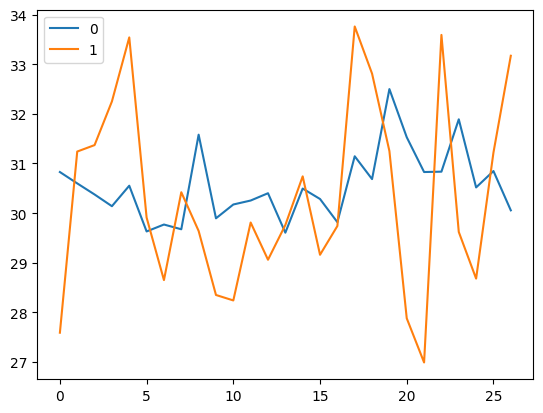

In [975]:
# Predict on the test set
y_pred = rfr.predict(X_test)
pd.DataFrame([y_pred, y_test]).T.plot()

In [745]:
gbr = GradientBoostingRegressor(n_estimators=10, random_state=22)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(n_estimators=10, random_state=22)

In [746]:
bgr_pred = gbr.predict(X_test)
pd.DataFrame([bgr_pred, y_test]).T.head(), pd.DataFrame([y_pred, y_test]).T.head()

(           0      1
 0  31.476193  27.59
 1  30.307197  31.24
 2  31.525417  31.37
 3  29.658935  32.25
 4  30.234702  33.54,
            0      1
 0  31.870163  27.59
 1  30.007722  31.24
 2  32.106243  31.37
 3  29.397747  32.25
 4  30.186017  33.54)

In [747]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
df = pd.DataFrame([lr_pred, y_test]).T
df.head()

,0,1
0,30.714055,27.59
1,31.000308,31.24
2,31.077774,31.37
3,29.671130,32.25
4,30.720933,33.54


In [749]:
# The coefficients
print("Coefficients: \n", lr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, lr_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, lr_pred))

Coefficients: 
 [-0.0858089  -0.00851786  0.00366179  0.01973253 -0.12522933 -0.26508712
 -0.00070039  0.00067011  0.1405574  -0.0051745   0.00284952]
Mean squared error: 4.25
Coefficient of determination: -0.17


In [814]:
svm = SVR()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
pd.DataFrame([y_pred, y_test]).T.describe()

,0,1
count,27.000000,27.000000
mean,30.599819,30.312593
std,0.121266,1.940421
min,30.370166,26.990000
25%,30.526266,28.870000
50%,30.577260,29.810000
75%,30.673580,31.310000
max,30.796658,33.760000


#### Model Evalution

In [815]:
# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

Root Mean Squared Error (RMSE): 1.94
R² Score: -0.03
Mean Absolute Error (MAE): 1.64


<Axes: >

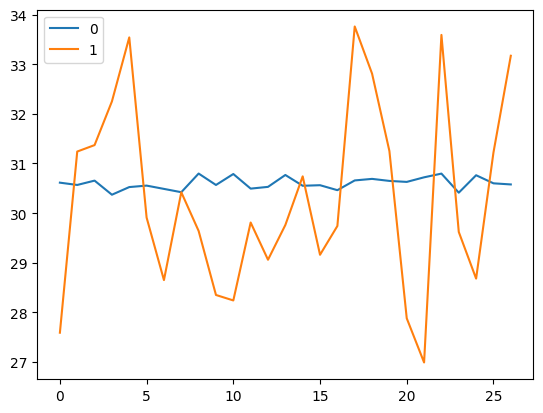

In [818]:
pd.DataFrame([y_pred, y_test]).T.plot()

#### Hyper-parameter Tuning

In [806]:
# Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, None],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 2, 4]
}



In [812]:
grid_search = GridSearchCV(estimator=rfr, param_grid=param_grid, cv = 5)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [10, 15, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 7],
                         'n_estimators': [100, 200, 300]})

<Axes: >

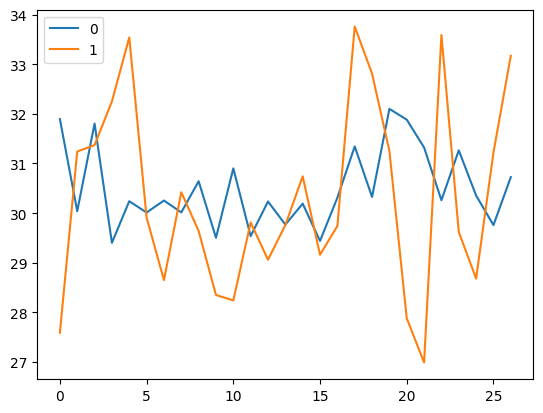

In [813]:
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
pd.DataFrame([y_pred_best, y_test]).T.plot()
# y_pred_best
# y_test

In [75]:

# Evaluate the best model
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_best = r2_score(y_test, y_pred_best)
mae_best = mean_absolute_error(y_test, y_pred_best)

print("\nAfter Hyperparameter Tuning:")
print(f"Best Model RMSE: {rmse_best:.2f}")
print(f"Best Model R² Score: {r2_best:.2f}")
print(f"Best Model MAE: {mae_best:.2f}")



After Hyperparameter Tuning:
Best Model RMSE: 2.08
Best Model R² Score: -0.19
Best Model MAE: 1.68


#### Model Prediction

In [ ]:
Xnew = crop_data[crop_data["Sowing_Season"]==2].drop("Current_price", axis = 1)
y_new = crop_data[crop_data["Sowing_Season"]==2]["Current_price"]
print(y_new.values)
print(Xnew)

In [340]:
print(f"Real value: {y_new.values}\nHyperparams_Predicted value: {rfr.predict(Xnew)}\nHyperparams_Predicted value: {best_model.predict(Xnew)}")

C:\Users\nares\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


ValueError: could not convert string to float: 'Karnataka'